In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import psutil
import cProfile
import pstats
import time
import math

In [2]:
def Basis_Function(X, k):
    if k == 1:
        A = np.column_stack((np.ones_like(X), (1 - X)))
    elif k == 2:
        A = np.column_stack((np.ones_like(X), (1 - X), 0.5 * (2 - 4*X + X**2)))
    elif k == 3:
        A = np.column_stack((np.ones_like(X), (1 - X), 0.5 * (2 - 4*X + X**2), 
                             1/6 * (6 - 18*X + 9*X**2 - X**3)))
    elif k == 4:
        A = np.column_stack((np.ones_like(X), (1 - X), 0.5 * (2 - 4*X + X**2), 
                             1/6 * (6 - 18*X + 9*X**2 - X**3), 
                             1/24 * (24 - 96*X + 72*X**2 - 16*X**3 + X**4)))
    elif k == 5:
        A = np.column_stack((np.ones_like(X), (1 - X), 0.5 * (2 - 4*X + X**2), 
                             1/6 * (6 - 18*X + 9*X**2 - X**3), 
                             1/24 * (24 - 96*X + 72*X**2 - 16*X**3 + X**4), 
                             1/120 * (120 - 600*X + 600*X**2 - 200*X**3 + 25*X**4 - X**5)))
    else:
        raise ValueError('Too many basis functions requested')
    
    return A

In [3]:
def LSM_PUT(T, r, sigma, K, S0, N, M, k):
    # Time steps
    dt = T / N
    # Time vector
    t = np.linspace(0, T, N + 1)
    # Generate random values
    z = np.random.randn(M // 2)
    x = (r - sigma**2 / 2) * T + sigma * np.sqrt(T) * np.concatenate((z, -z))
    S = S0 * np.exp(x)
    # Payoff at time T
    P = np.maximum(K - S, 0)  
    # Initialize C for all paths
    C = np.zeros(M)  
    # Initialize exercise boundary
    exercise_boundary=[]

    for i in range(N - 1, 0, -1):
        z = np.random.randn(M // 2)
        x = t[i] * x / t[i + 1] + sigma * np.sqrt(dt * t[i] / t[i + 1]) * np.concatenate((z, -z))
        S = S0 * np.exp(x)
        
        # In-the-money paths
        itmP = np.where(K - S > 0)[0]  
        
        # Perform regression to estimate coefficients
        X = S[itmP]  # Prices for the in-the-money paths
        Y = P[itmP] * np.exp(-r * dt)  # Discounted payoffs
        A = Basis_Function(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]  
        # Estimated value of continuation
        C = A.dot(beta)  
        # Value of immediate exercise
        E = K - X  
        # Paths where it's better to exercise
        exP = itmP[C < E]  
        # Set exercise boundary
        exercise_boundary.append([i,S[exP]])
        
        rest = np.setdiff1d(np.arange(M), exP)  # Rest of the paths
        
        P[exP] = E[C < E]  # Better to exercise? Insert value in payoff vector
        P[rest] = P[rest] * np.exp(-r * dt)  # Better to continue? Insert previous payoff and discount back one step
        
    # Calculate the final price
    option_price = np.mean(P * np.exp(-r * dt))
    return exercise_boundary, option_price

In [4]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 90.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 4 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [5]:
%%time
# Call the Gustafsson function
exercise_boundaryp90, price= LSM_PUT(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Gustafsson Option Price: ${price:.4f}")

Gustafsson Option Price: $10.7270
CPU times: total: 1min 10s
Wall time: 1min 9s


In [6]:
cProfile.run("exercise_boundary, price = LSM_PUT(T, r, sigma, K, S0, N, M, k)", "profile_results")

In [7]:
stats = pstats.Stats("profile_results")
stats.strip_dirs()  # Remove extraneous path from the file names
stats.sort_stats("cumulative")  # Sort by cumulative time

# Print the profiling statistics
stats.print_stats()

Fri Oct 27 21:11:09 2023    profile_results

         176006 function calls (162138 primitive calls) in 64.885 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   64.885   64.885 {built-in method builtins.exec}
        1    0.000    0.000   64.885   64.885 <string>:1(<module>)
        1    9.725    9.725   64.885   64.885 3744123224.py:1(LSM_PUT)
      999   29.055    0.029   32.941    0.033 4175462510.py:1(Basis_Function)
19865/5997    4.284    0.000   21.751    0.004 {built-in method numpy.core._multiarray_umath.implement_array_function}
      999    0.008    0.000   10.564    0.011 <__array_function__ internals>:177(lstsq)
      999   10.472    0.010   10.547    0.011 linalg.py:2150(lstsq)
      999    0.007    0.000    6.956    0.007 <__array_function__ internals>:177(setdiff1d)
      999    1.186    0.001    6.931    0.007 arraysetops.py:939(setdiff1d)
     1999    0.013    0.000    3.865   

In [8]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 100.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 4 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
%%time
# Call the Gustafsson function
exercise_boundaryp100, price= LSM_PUT(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Gustafsson Option Price: ${price:.4f}")

Gustafsson Option Price: $4.8404
CPU times: total: 42.3 s
Wall time: 42.3 s


In [10]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 110.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 4 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [11]:
%%time
# Call the Gustafsson function
exercise_boundaryp110, price= LSM_PUT(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Gustafsson Option Price: ${price:.4f}")

Gustafsson Option Price: $1.8341
CPU times: total: 22.7 s
Wall time: 22.9 s


In [12]:
def Standard_Stock_Path(T,N,M):
    dt = T/N
    t = np.linspace(0, T, N + 1)
    z = np.random.randn(N, M)
    S = np.zeros((N+1, M))
    S[0,:] = S0
    for i in range(1,N+1):
        S[i,:] = S[i-1,:] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z[i-1,:])
    return S

In [13]:
def Standard_LSM_PUT(T, r, sigma, K, S0, N, M, k):
    # Time steps
    dt = T / N
    
    # Time vector
    t = np.linspace(0, T, N + 1)
    C = np.zeros(M)  # Initialize C for all paths
    S = Standard_Stock_Path(T,N,M)
    P = np.maximum(K - S[-1,:], 0)
    exercise_boundary=[]# Initialize exercise boundary

    for i in range(N - 1, 0, -1):
#        
        itmP = np.where(K - S[i,:] > 0)[0]  
        # print(itmP)
         # Perform regression to estimate coefficients
        X = S[i,:][itmP]  # Prices for the in-the-money paths
        Y = P[itmP] * np.exp(-r * dt)  # Discounted payoffs
        A = Basis_Function(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]  
        C = A.dot(beta)  # Estimated value of continuation

        E = K - X  # Value of immediate exercise
        
        exP = itmP[C < E]  # Paths where it's better to exercise
        #exercise_boundary[i] = np.mean(S[exP][:, i])
        exercise_boundary.append([i,S[i,:][exP]])
        rest = np.setdiff1d(np.arange(M), exP)  # Rest of the paths
        
        P[exP] = E[C < E]  # Better to exercise? Insert value in payoff vector
        P[rest] = P[rest] * np.exp(-r * dt)  # Better to continue? Insert previous payoff and discount back one step
        
    # Calculate the final price
    price = np.mean(P* np.exp(-r * dt))

    #return exercise_boundary
    return exercise_boundary,price

In [14]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 90.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 4 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [15]:
%%time
# Call the Standard_LSM function
exercise_boundary, price = Standard_LSM_PUT(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Longstaff Option Price: ${price:.4f}")

Longstaff Option Price: $10.7293
CPU times: total: 1min 10s
Wall time: 1min 10s


In [16]:
cProfile.run("exercise_boundary, price = Standard_LSM_PUT(T, r, sigma, K, S0, N, M, k)", "profile_results")

In [17]:
stats = pstats.Stats("profile_results")
stats.strip_dirs()  # Remove extraneous path from the file names
stats.sort_stats("cumulative")  # Sort by cumulative time

# Print the profiling statistics
stats.print_stats()

Fri Oct 27 21:14:36 2023    profile_results

         172217 function calls (158327 primitive calls) in 71.762 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   71.762   71.762 {built-in method builtins.exec}
        1    0.142    0.142   71.762   71.762 <string>:1(<module>)
        1    6.806    6.806   71.621   71.621 3808048041.py:1(Standard_LSM_PUT)
      999   29.434    0.029   33.335    0.033 4175462510.py:1(Basis_Function)
18888/4998    4.174    0.000   22.693    0.005 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    4.824    4.824   11.504   11.504 1581817349.py:1(Standard_Stock_Path)
      999    0.008    0.000   11.223    0.011 <__array_function__ internals>:177(lstsq)
      999   11.122    0.011   11.203    0.011 linalg.py:2150(lstsq)
      999    0.007    0.000    7.357    0.007 <__array_function__ internals>:177(setdiff1d)
      999    1.241    0

In [18]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 100.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 4 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
%%time
# Call the Standard_LSM function
exercise_boundary, price = Standard_LSM_PUT(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Longstaff Option Price: ${price:.4f}")

Longstaff Option Price: $4.8381
CPU times: total: 53.1 s
Wall time: 53.8 s


In [20]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 110.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 4 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [21]:
%%time
# Call the Standard_LSM function
exercise_boundary, price = Standard_LSM_PUT(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Longstaff Option Price: ${price:.4f}")

Longstaff Option Price: $1.8204
CPU times: total: 27.1 s
Wall time: 27.1 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


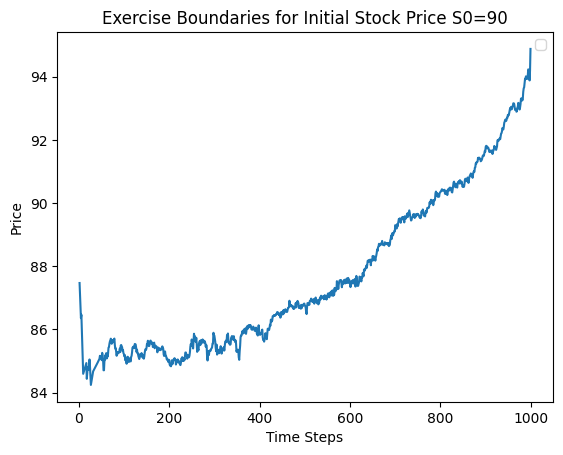

In [22]:
x=[]
y=[]
for item in exercise_boundaryp90:
    if len(item[1]) > 0:
        x.append([item[0]])
        y.append(np.max(item[1]))
    else:
        pass
        
if x and y:
        plt.plot(x, y)

plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.title('Exercise Boundaries for Initial Stock Price S0=90')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


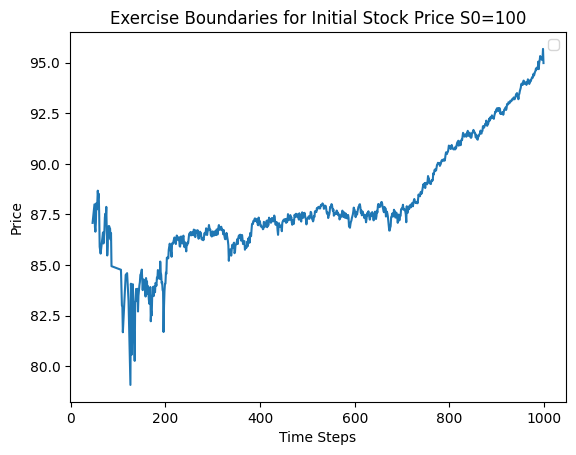

In [23]:
x=[]
y=[]
for item in exercise_boundaryp100:
    if len(item[1]) > 0:
        x.append([item[0]])
        y.append(np.max(item[1]))
    else:
        pass
        
if x and y:
        plt.plot(x, y)

plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.title('Exercise Boundaries for Initial Stock Price S0=100')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


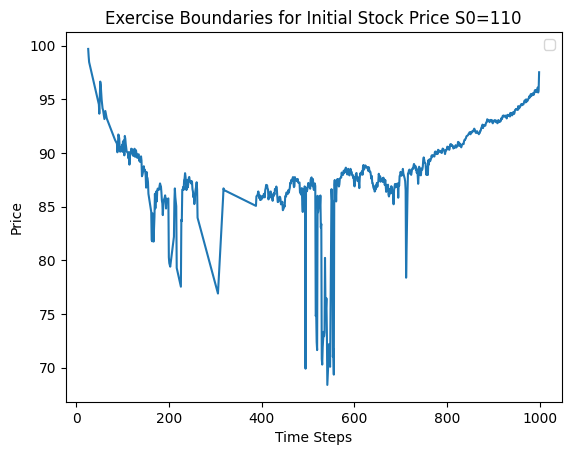

In [24]:
x=[]
y=[]
for item in exercise_boundaryp110:
    if len(item[1]) > 0:
        x.append([item[0]])
        y.append(np.max(item[1]))
    else:
        pass
        
if x and y:
        plt.plot(x, y)

plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.title('Exercise Boundaries for Initial Stock Price S0=110')
plt.show()

In [25]:
def black_scholes_call_option_price(S, K, T, r, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    N_d1 = norm_cdf(d1)
    N_d2 = norm_cdf(d2)
    
    call_option_price = S * N_d1 - K * math.exp(-r * T) * N_d2
    
    return call_option_price

def norm_cdf(x):
    # Cumulative distribution function for the standard normal distribution
    from scipy.stats import norm
    return norm.cdf(x)

In [26]:
def LSM_CALL(T, r, sigma, K, S0, N, M, k):
    # Time steps
    dt = T / N
    # Time vector
    t = np.linspace(0, T, N + 1)
    # Generate random values
    z = np.random.randn(M // 2)
    x = (r - sigma**2 / 2) * T + sigma * np.sqrt(T) * np.concatenate((z, -z))
    S = S0 * np.exp(x)
    # Payoff at time T
    P = np.maximum(S-K, 0)  
    # Initialize C for all paths
    C = np.zeros(M)  
    #C = np.maximum(S - K,0)
    # Initialize exercise boundary
    exercise_boundary=[]
    fig, ax = plt.subplots()

    for i in range(N-1, 0, -1):
        z = np.random.randn(M // 2)
        x = t[i] * x / t[i+1] + sigma * np.sqrt(dt * t[i] / t[i+1]) * np.concatenate((z, -z))
        S = S0 * np.exp(x)
        
        # In-the-money paths
        itmP = np.where(S-K > 0)[0]  
        
        # Perform regression to estimate coefficients
        X = S[itmP]  # Prices for the in-the-money paths
        Y = P[itmP] * np.exp(-r * dt)  # Discounted payoffs
        A = Basis_Function(X, k)
        beta = np.linalg.lstsq(A, Y, rcond=None)[0]  
        # Estimated value of continuation
        C = A.dot(beta)  
        # Value of immediate exercise
        E = X-K  
        # Paths where it's better to exercise
        exP = itmP[C < E]  
        # Set exercise boundary
        exercise_boundary.append([i,S[exP]])
        optimal_stock_price = S[exP]
        plot_call = [[i, x] for x in optimal_stock_price]
        time_values = [x[0] for x in plot_call]
        price_values = [y[1] for y in plot_call]
        ax.scatter(time_values, price_values, label=f'Iteration {i}', s=0.07, color='red')
        
        rest = np.setdiff1d(np.arange(M), exP)  # Rest of the paths
        
        P[exP] = E[C < E]  # Better to exercise? Insert value in payoff vector
        P[rest] = P[rest] * np.exp(-r * dt)  # Better to continue? Insert previous payoff and discount back one step
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Stock Price')
    ax.set_title('Call Option Exercise Boundary')
        
    # Calculate the final price
    option_price = np.mean(P * np.exp(-r * dt))
    return exercise_boundary, option_price

In [27]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 90.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 4 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
%%time
call_price = black_scholes_call_option_price(S0, K, T, r, sigma)
print(f"Black Scholes Call Option Price: ${call_price:.4f}")

Black Scholes Call Option Price: $2.7584
CPU times: total: 0 ns
Wall time: 7.55 ms


Gustafsson Option Price: $2.7507
CPU times: total: 46 s
Wall time: 47.5 s


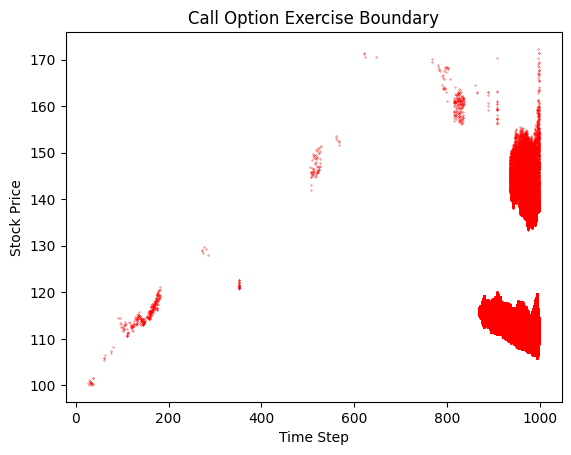

In [30]:
%%time
# Call the Gustafsson function
exercise_boundaryc, price= LSM_CALL(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Gustafsson Option Price: ${price:.4f}")

In [31]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 100.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 4 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [32]:
%%time
call_price = black_scholes_call_option_price(S0, K, T, r, sigma)
print(f"Black Scholes Call Option Price: ${call_price:.4f}")

Black Scholes Call Option Price: $7.4851
CPU times: total: 0 ns
Wall time: 997 µs


Gustafsson Option Price: $7.4508
CPU times: total: 1min 3s
Wall time: 1min 2s


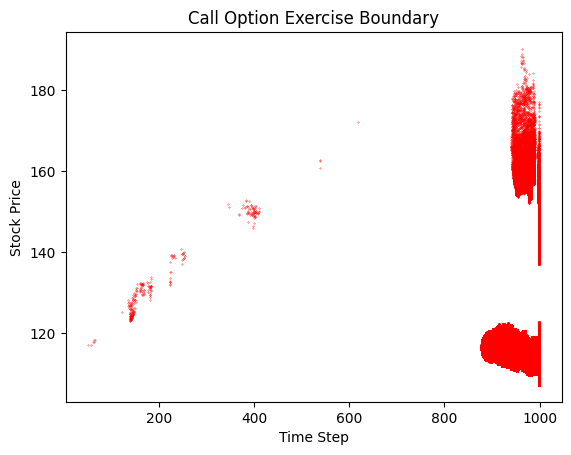

In [33]:
%%time
# Call the Gustafsson function
exercise_boundaryc, price= LSM_CALL(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Gustafsson Option Price: ${price:.4f}")

In [34]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 110.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 4 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [35]:
%%time
call_price = black_scholes_call_option_price(S0, K, T, r, sigma)
print(f"Black Scholes Call Option Price: ${call_price:.4f}")

Black Scholes Call Option Price: $14.7020
CPU times: total: 15.6 ms
Wall time: 1.15 ms


Gustafsson Option Price: $14.6446
CPU times: total: 1min 10s
Wall time: 1min 8s


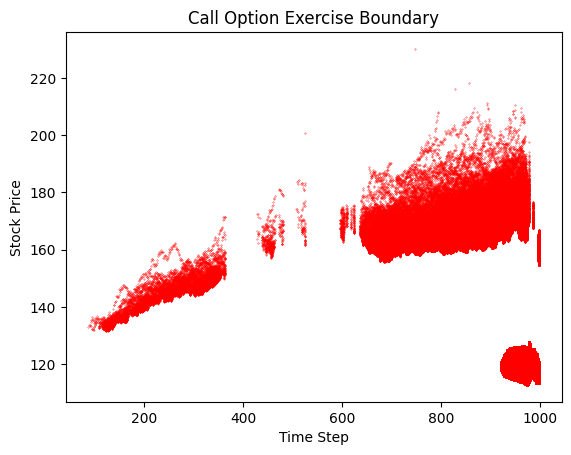

In [36]:
%%time
# Call the Gustafsson function
exercise_boundaryc, price= LSM_CALL(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Gustafsson Option Price: ${price:.4f}")

In [37]:
# Set the common parameters
T = 1.0
r = 0.03
sigma = 0.15
K = 100
N_min = 10
N_max = 200
N_step = 5
M = 100000
k_max = 4 # Maximum number of basis functions

S0=90
true_option_price =10.726486710094511
# Create arrays to store the results
relative_errors = np.zeros((39,4))

for k in range(1, k_max + 1):
    for N in range(N_min, N_max + 1, N_step):
        y = (N - N_min) // N_step
        _, option_price = LSM_PUT(T, r, sigma, K, S0, N, M, k)  # Fixed this line
        relative_errors[y,k-1] = abs((option_price-true_option_price)/true_option_price)

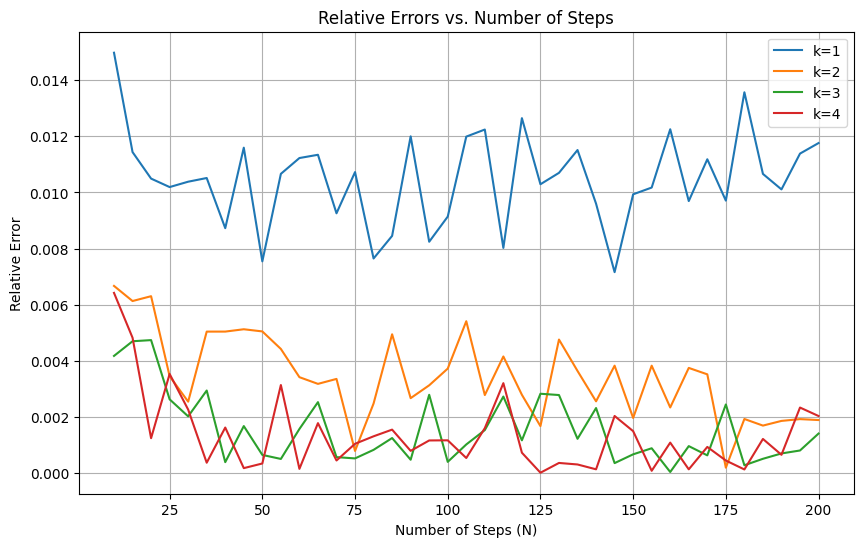

In [38]:
# Create the plot
plt.figure(figsize=(10, 6))

for k in range(1, k_max + 1):
    plt.plot(range(N_min, N_max + 1, N_step), relative_errors[:, k-1], label=f'k={k}')

plt.title('Relative Errors vs. Number of Steps')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Relative Error')
plt.legend()
plt.grid(True)
plt.show()


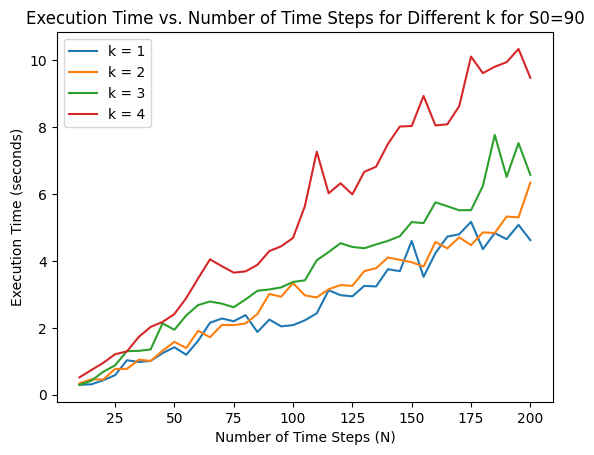

CPU times: total: 9min 57s
Wall time: 9min 38s


In [40]:
%%time
# Set the common parameters
T = 1.0
r = 0.03
sigma = 0.15
K = 100
N_min = 10
N_max = 200
N_step = 5
M = 100000
k_max = 4  # Maximum number of basis functions
S0=90

# Create arrays to store the execution times
execution_times = []

for k in range(1, k_max + 1):
        times = []  # To store execution times
        for N in range(N_min, N_max + 1, N_step):
            start_time = time.time()
            _, _ = LSM_PUT(T, r, sigma, K, S0, N, M, k)
            end_time = time.time()
            elapsed_time = end_time - start_time
            times.append(elapsed_time)
        
        execution_times.append(times)    

# Now you can access the execution times for each set of parameters
for k, times in enumerate(execution_times):
    N_values = list(range(N_min, N_max + 1, N_step))
    plt.plot(N_values, times, label=f'k = {k + 1}')

plt.xlabel('Number of Time Steps (N)')
plt.ylabel('Execution Time (seconds)')
plt.legend()
plt.title('Execution Time vs. Number of Time Steps for Different k for S0=90')
plt.show()

In [42]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 90.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 1 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [43]:
%%time
# Call the Gustafsson function
exercise_boundaryp90, price= LSM_PUT(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Gustafsson Option Price: ${price:.4f}")

Gustafsson Option Price: $10.6029
CPU times: total: 26.7 s
Wall time: 26.7 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


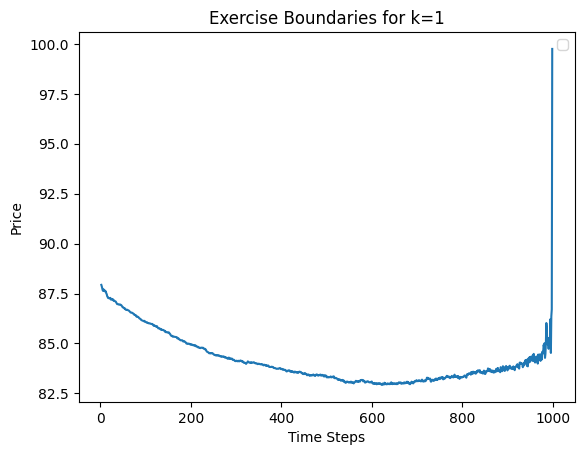

In [45]:
x=[]
y=[]
for item in exercise_boundaryp90:
    if len(item[1]) > 0:
        x.append([item[0]])
        y.append(np.max(item[1]))
    else:
        pass
        
if x and y:
        plt.plot(x, y)

plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.title('Exercise Boundaries for k=1')
plt.show()

In [46]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 90.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 2 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [47]:
%%time
# Call the Gustafsson function
exercise_boundaryp90, price= LSM_PUT(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Gustafsson Option Price: ${price:.4f}")

Gustafsson Option Price: $10.6817
CPU times: total: 31.5 s
Wall time: 31.2 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


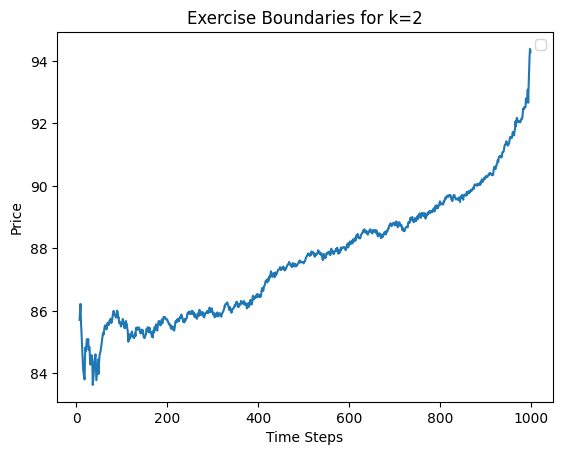

In [51]:
x=[]
y=[]
for item in exercise_boundaryp90:
    if len(item[1]) > 0:
        x.append([item[0]])
        y.append(np.max(item[1]))
    else:
        pass
        
if x and y:
        plt.plot(x, y)

plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.title('Exercise Boundaries for k=2')
plt.show()

In [49]:
%%time
# Set input parameters
T = 1.0  # Time to maturity
r = 0.03  # Risk-free interest rate
sigma = 0.15  # Volatility
K = 100.0  # Strike price
S0 = 90.0  # Initial stock price
N = 1000 # Number of time steps
M = 100000 # Number of paths
k = 3 # Number of basis functions

CPU times: total: 0 ns
Wall time: 0 ns


In [50]:
%%time
# Call the Gustafsson function
exercise_boundaryp90, price= LSM_PUT(T, r, sigma, K, S0, N, M, k)
# Print the price value
print(f"Gustafsson Option Price: ${price:.4f}")

Gustafsson Option Price: $10.7031
CPU times: total: 40.5 s
Wall time: 39.1 s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


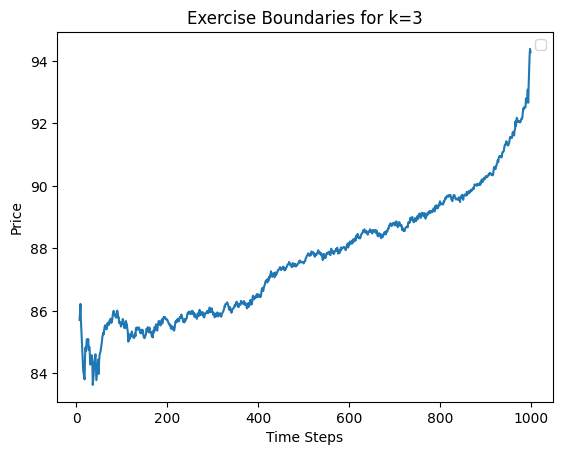

In [52]:
x=[]
y=[]
for item in exercise_boundaryp90:
    if len(item[1]) > 0:
        x.append([item[0]])
        y.append(np.max(item[1]))
    else:
        pass
        
if x and y:
        plt.plot(x, y)

plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.title('Exercise Boundaries for k=3')
plt.show()